In [1]:

%load_ext autoreload
%autoreload 2



from jax import config
config.update("jax_enable_x64", True)
import jax
import json
from jax.tree_util import Partial


from dataclasses import dataclass
import warnings
from typing import List, Union

import cola

import jax.numpy as jnp
import jax.random as jr
from jaxtyping import (
    Array,
    Float,
    install_import_hook,
    Num,
)
import tensorflow_probability.substrates.jax.bijectors as tfb

#with install_import_hook("gpjax", "beartype.beartype"):
import gpjax as gpx
from gpjax.typing import (
    Array,
    ScalarInt,
    ScalarFloat,
)
from gpjax.distributions import GaussianDistribution

import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
colors = rcParams["axes.prop_cycle"].by_key()["color"]



import gpjax as gpx
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
key = jr.PRNGKey(123)

import scipy.optimize as spo
from dataclasses import dataclass
from gpjax.base import param_field, static_field
import math
from gpjax.kernels.base import AbstractKernel
from gpjax.kernels import RBF
import optax as ox
from gpjax.kernels.stationary.utils import squared_distance
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd
from gpjax.typing import (
    Array,
    ScalarFloat,
)
from jaxtyping import (
    Float,
    Num,
)

from optax import GradientTransformation
import jax.tree_util as jtu





In [2]:

def optim_builder(optim_pytree):

    def _init_leaf(o, p):
        if isinstance(o, GradientTransformation):
            return o.init(p)
        else:
            return None

    def _update_leaf(o, u, s, p):
        if isinstance(o, GradientTransformation):
            return tuple(o.update(u, s, p))
        else:
            return jtu.tree_map(jnp.zeros_like, p)

    def _get_updates(o, u, p):
        if isinstance(o, GradientTransformation):
            return u[0]
        else:
            return u
    
    def _get_state(o, u):
        if isinstance(o, GradientTransformation):
            return u[1]
        else:
            return None

    def init_fn(params):
        return jtu.tree_map(_init_leaf, optim_pytree, params, is_leaf=lambda x: isinstance(x, GradientTransformation))

    def update_fn(updates, state, params):
        updates_state = jtu.tree_map(_update_leaf, optim_pytree, updates, state, params, is_leaf=lambda x: isinstance(x, GradientTransformation))
        updates = jtu.tree_map(_get_updates, optim_pytree, updates_state, params, is_leaf=lambda x: isinstance(x, GradientTransformation))
        state = jtu.tree_map(_get_state, optim_pytree, updates_state, is_leaf=lambda x: isinstance(x, GradientTransformation))

        return updates, state

    return GradientTransformation(init_fn, update_fn)


# 100_000 entries sampled across time/lat/lon over first day of data

## X2D has:

0"Sea surface temperature (K)"

1"Sensible heat flux (W/m^2)"

2"Latent heat flux (W/m^2)"

3"Vertically-integrated moisture convergence (kg/m^2)"

4"Column relative humidity (%)"


## X3D has:

0"Absolute temperature (K)"

1"Relative humidity (%)"

2"Specific humidity (kg/kg)"

3"Geopotential height (m^2 s^-2)"

4"Zonal wind (m/s)"

5"Meridional wind (m/s)"

6"Potential temperature (K)"

7"Equivalent potential temperature (K)"

8"Equivalent potential temperature saturation deficit (K)"

9"Saturated equivalent potential temperature (K)"

10"MSE-conserving plume buoyancy (m/s^2)"


## static has:

0"Land-sea mask"

1"Angle of sub-gridscale orography (rad)Anisotropy of sub-gridscale orography"

2"Standard deviation of sub-gridscale orography"

3"Slope of sub-gridscale orography"

## Y has:

0"ERA5 Precipitation (mm/hr)"

1"TRMM Precipitation (mm/hr)"

2"TRMM Relative Error (%)"

# plev are
1000.,   2000.,   3000.,   5000.,   7000.,  10000., 15000.,
20000.,  25000.,  30000.,  40000.,  50000.,  60000.,  70000.,80000.,  85000.,  90000.,  92500.,  95000.,  97500., 100000.


In [3]:
# load data
X2d = jnp.array(jnp.load("..//data/100_000_one_day/X2D_sample.npy"), dtype=jnp.float64) # [N, D]
X3d = jnp.array(jnp.load("../data/100_000_one_day/X3D_sample.npy"), dtype=jnp.float64) # [N, D]
Xstatic = jnp.array(jnp.load("../data/100_000_one_day/XSTATIC_sample.npy"), dtype=jnp.float64) # [N, D]
Y = jnp.array(jnp.load("../data/100_000_one_day/Y_sample.npy"), dtype=jnp.float64) # [N, 1]
pressure = jnp.array([[1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,60000,70000,80000, 85000,90000,92500,95000,97500,100000]], dtype=jnp.float64)


# look at ERA5 rain
Y = Y[:,0:1]  

# remove any entries with nan
X3d_nan_idx = jnp.isnan(X3d).any(axis=1).any(axis=1)
X2d_nan_idx = jnp.isnan(X2d).any(axis=1)
Xstatic_nan_idx = jnp.isnan(Xstatic).any(axis=1)
Y_nan_idx = jnp.isnan(Y).any(axis=1)
any_nan = X3d_nan_idx | X2d_nan_idx | Y_nan_idx | Xstatic_nan_idx
no_nan = ~ any_nan
print(f"Removed {any_nan.sum()} entries with nan")
X2d = X2d[no_nan,:]
X3d = X3d[no_nan,:,:]
Xstatic = Xstatic[no_nan,:]
Y = Y[no_nan,:]


# just keep the "prognostic" inputs that joe considered (for now)
# RH, tehta_e^+, theta_e, theta_e^*
names_3d =  ["RH", "tehta_e+", "theta_e", "theta_e*"]
idx_3d = [1, 9, 7, 8 ]
X3d = X3d[:,idx_3d,:]


# # also include his "normalised" sigma_o
# sigma_o = jnp.where(Xstatic[:,0]<0.5, 0.0, 1.0+jnp.log(1+Xstatic[:,2]))
# X2d = sigma_o[:,None]


#remove all pressure levels below 500 hPA
lowest_idx = 11 # 7
print(f"Removed all pressure levels below {pressure[:,lowest_idx]} hPa")

X3d = X3d[:, :, lowest_idx:]
pressure_levels = pressure[:,lowest_idx:]

# remove no rain days
print(f"Removed {(Y[:,0]>0).sum()} entries with zero rain")
X3d = X3d[Y[:,0]>0,:]
X2d = X2d[Y[:,0]>0,:]
Y = Y[Y[:,0]>0,:]
# also log Y
print(f"Applied log transform to Y")
Y = jnp.log(Y)
print(f"then standardized Y")
Y_mean = jnp.mean(Y)
Y_std = jnp.std(Y)
Y = (Y - Y_mean) / Y_std

# standardize inputs
X3d_std = jnp.std(X3d, axis=0)
X3d_mean = jnp.mean(X3d,axis=0)
X3d = (X3d - X3d_mean) / X3d_std
X2d_std = jnp.std(X2d, axis=0)
X2d_mean = jnp.mean(X2d,axis=0)
X2d = (X2d - X2d_mean) / X2d_std


# look at tiny data for now
N_train = 10_000
print(f"Only using {N_train} training points!")
X3d_train, X2d_train, Y_train = X3d[:N_train,:],X2d[:N_train,:], Y[:N_train,:]
num_2d_variables= X2d_train.shape[-1]
print(f"using {num_2d_variables} 2d variables")
X_train = jnp.hstack((X3d_train.reshape(len(X3d_train), -1), X2d_train))



Removed 24779 entries with nan
Removed all pressure levels below [50000.] hPa
Removed 56920 entries with zero rain
Applied log transform to Y
then standardized Y
Only using 10000 training points!
using 5 2d variables


In [4]:
@dataclass
class VerticallyIntegratedKernel(AbstractKernel):
    base_kernel: AbstractKernel = gpx.kernels.RBF()
    smoother_mean: Float[Array, " D"]  = param_field(None)
    smoother_input_scale: Float[Array, " D"] = param_field(None, bijector=tfb.Softplus(low=jnp.array(1.0e-5, dtype=jnp.float64)))
    #smoother_bias: Float[Array, " D"] = param_field(None, bijector=tfb.Softplus(low=jnp.array(1.0e-5, dtype=jnp.float64)))
    #smoother_output_scale: Float[Array, " D"] = param_field(None, bijector=tfb.Softplus(low=jnp.array(1.0e-5, dtype=jnp.float64)))
    Z_levels: Float[Array, " D"] = static_field(pressure_levels)
   
    def __post_init__(self):
        self.Z_mean = jnp.mean(self.Z_levels)
        self.Z_std = jnp.std(self.Z_levels)
        self.Z_levels = (self.Z_levels - self.Z_mean) / self.Z_std

    def __call__(self, x, y):
        x, y = self.slice_input(x), self.slice_input(y)
        smoothed_x, smoothed_y = self._smooth(x), self._smooth(y)
        return self.base_kernel(smoothed_x, smoothed_y )
    
    def _smooth(self, x): # [d*z] -> [d]
        x_to_smooth = x.reshape(-1,self.Z_levels.shape[1]) # [d, z]
        smoothing_weights = jnp.exp(-0.5*((self.Z_levels-self.smoother_mean.T)/(self.smoother_input_scale.T))**2) # [d, z]
        smoothing_weights = (smoothing_weights/ jnp.sum(smoothing_weights, axis=-1, keepdims=True)) # [d, z]
        return jnp.sum(jnp.multiply(smoothing_weights ,x_to_smooth), axis=-1) # [d]
    


def prep_kernel(D: gpx.Dataset, num_2d_variables:int, bij_lengthscale:bool = True):
    lengthscale_bij = tfb.SoftClip(jnp.array(1e-2, dtype=jnp.float64),jnp.array(1e2, dtype=jnp.float64))
    base_kernel = RBF(lengthscale=jnp.array([1.0]*4), variance = jnp.var(D.y))
    if bij_lengthscale:
        base_kernel = base_kernel.replace_bijector( lengthscale = lengthscale_bij)
    kernel_3d = VerticallyIntegratedKernel(
        base_kernel = base_kernel, 
        smoother_mean = jnp.array([[0.0]*4]),
        smoother_input_scale = jnp.array([[1.0]*4]),
        active_dims=jnp.arange(X_train.shape[-1])[:-num_2d_variables]
        )
    kernel_2d = RBF(lengthscale=jnp.array([0.1]*num_2d_variables), active_dims=jnp.arange(X_train.shape[-1])[-num_2d_variables:])
    kernel_2d = kernel_2d.replace_trainable( variance = False)
    if bij_lengthscale:
        kernel_2d = kernel_2d.replace_bijector( lengthscale = lengthscale_bij)
    return kernel_3d * kernel_2d


@dataclass
class Gamma(gpx.likelihoods.AbstractLikelihood):
    v: Float[Array, "#N"] = param_field(
        jnp.array(10.0), bijector=tfb.Softplus()
    )
    def link_function(self, f):
        #https://www2.imm.dtu.dk/pubdb/edoc/imm6637.pdf
        #C = jax.scipy.stats.norm.cdf(f)
        C = jnp.exp(f)
        return tfd.Gamma(self.v, C, allow_nan_stats=False)

    def predict(self, dist: tfd.Distribution) -> tfd.Distribution:
        raise NotImplementedError
    
@dataclass
class Exponential(gpx.likelihoods.AbstractLikelihood):
    def link_function(self, f):
        C = jnp.exp(f)
        return tfd.Exponential(1/C)

    def predict(self, dist: tfd.Distribution) -> tfd.Distribution:
        raise NotImplementedError



def plot_params(model, title=None):
    if isinstance(model, gpx.variational_families.AbstractVariationalFamily):
        model = model.posterior
    plt.figure()
    opt_3d_kernel =model.prior.kernel.kernels[0]
    lengthscales = opt_3d_kernel.base_kernel.lengthscale
    #smoothing_weights = opt_3d_kernel.smoother_bias.T + (1 / (jnp.sqrt(2*math.pi)*opt_3d_kernel.smoother_input_scale.T))*jnp.exp(-0.5*(opt_3d_kernel.Z_levels-opt_3d_kernel.smoother_mean.T)**2/(opt_3d_kernel.smoother_input_scale).T) # [4, 21]
    #smoothing_weights = (jnp.exp(-0.5*((opt_3d_kernel.Z_levels-opt_3d_kernel.smoother_mean.T)/(opt_3d_kernel.smoother_input_scale.T))**2)) # [4, 21]
    smoothing_weights =  jnp.exp(-0.5*((opt_3d_kernel.Z_levels-opt_3d_kernel.smoother_mean.T)/(opt_3d_kernel.smoother_input_scale.T))**2) # [4, 21]
    smoothing_weights = (smoothing_weights/ jnp.sum(smoothing_weights, axis=-1, keepdims=True)) # [4, 21]
    for i in range(len(names_3d )):
        plt.plot(smoothing_weights[i,:].T,pressure_levels[0,:], label=f"{names_3d[i]} with lengthscales {lengthscales[i]:.2f}")
    plt.legend()
    plt.title(title+f"other lengthscales are {model.prior.kernel.kernels[1].lengthscale}")
    plt.gca().invert_yaxis()



  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

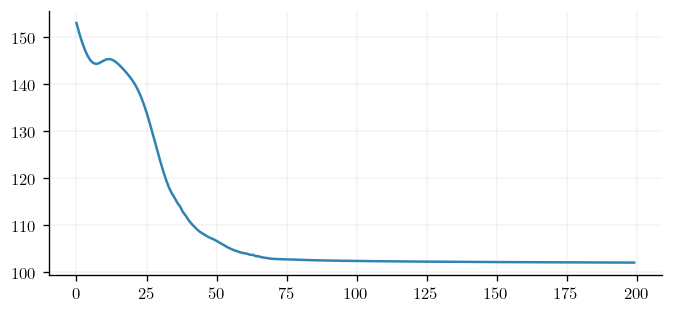

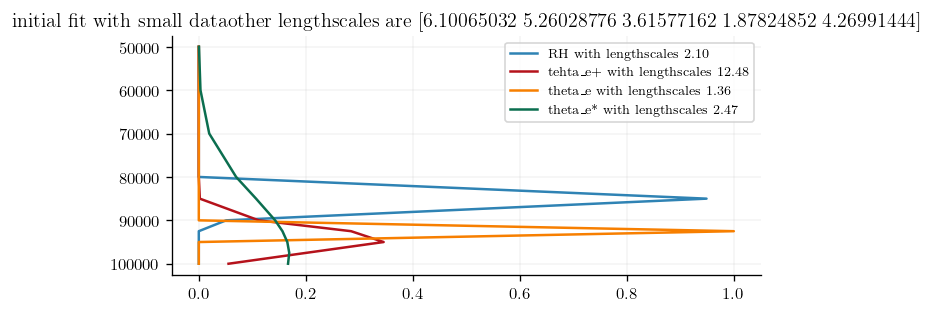

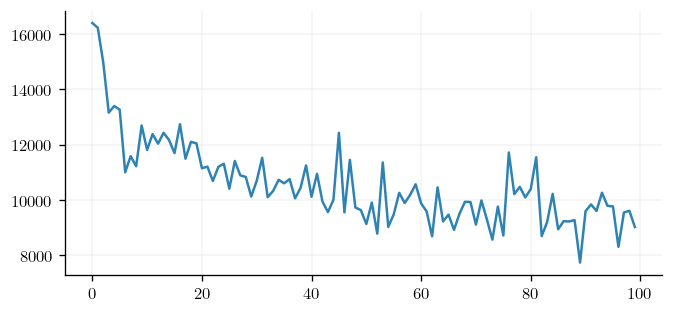

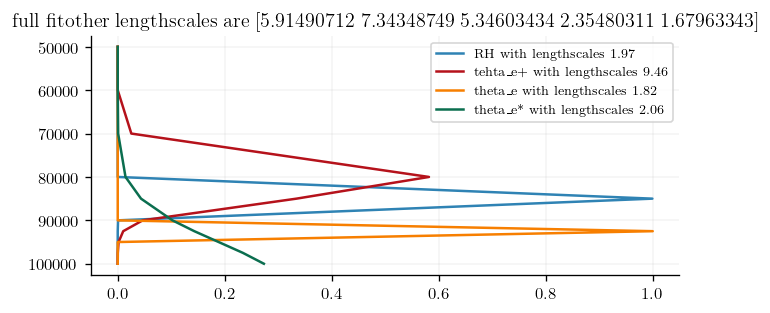

In [5]:
@dataclass
class VerticallyIntegratedKernel(VerticallyIntegratedKernel):
    dummy: AbstractKernel = gpx.kernels.RBF()

# prep fancy kernel for model
D = gpx.Dataset(X=X_train,y = Y_train)
prior = gpx.gps.Prior(mean_function= gpx.mean_functions.Zero(), kernel = prep_kernel(D, num_2d_variables))
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)


# first fit with small data to get init for SVGP
num_data_for_init=100
D_small = gpx.Dataset(X = D.X[:num_data_for_init,:],y = D.y[:num_data_for_init,:])
posterior = prior * likelihood
objective = jax.jit(gpx.objectives.ConjugateMLL(negative=True))
#objective = jax.jit(gpx.objectives.NonConjugateMLL(negative=True))
opt_posterior, history = gpx.fit(
    model=posterior,
    objective=objective,
    train_data=D_small,
    optim=ox.adam(learning_rate=1e-1),
    num_iters=200,
    key=jr.PRNGKey(42),
)
# opt_posterior, history = gpx.fit_scipy(
#     model=posterior,
#     objective=objective,
#     train_data=D_small,
# )
plt.plot(history)
plot_params(opt_posterior, title="initial fit with small data")



# choose inducing inputs and init SVGP
num_inducing = 100
#z = jr.normal(key, (num_inducing , D.X.shape[-1])) # todo enable this
z = D.X[:num_inducing,:]


init_posterior_at_inducing = opt_posterior.predict(z, D_small)
# todo try whitening ?
q = gpx.variational_families.VariationalGaussian(
    posterior=opt_posterior, 
    inducing_inputs=z,
    variational_mean= init_posterior_at_inducing.mean()[:,None],
    variational_root_covariance= jnp.linalg.cholesky(init_posterior_at_inducing.covariance()), # todo check this is right!
)

q = q.replace_trainable(inducing_inputs=False)
# q = q.replace_trainable(variational_mean=False)
# q = q.replace_trainable(variational_root_covariance=False)

objective = jax.jit(gpx.objectives.ELBO(negative=True))


def zero_grads():
    def init_fn(_): 
        return ()
    def update_fn(updates, state, params=None):
        return jax.tree_map(jnp.zeros_like, updates), ()
    return ox.GradientTransformation(init_fn, update_fn)

optim_pytree = q.replace(
    posterior = ox.adam(1e-1), 
    variational_mean = ox.adam(1e-2),
    variational_root_covariance = ox.adam(1e-2), 
    inducing_inputs= ox.adam(1e-2),
    )
optim = optim_builder(optim_pytree)

opt_q, history = gpx.fit(
    model=q,
    objective=objective,
    train_data=D,
    optim=optim,
    num_iters=100,
    key=jr.PRNGKey(42),
    batch_size=128,
)

plt.figure()
plt.plot(history)
plot_params(opt_q, title="full fit")
